In [1]:
from search import getlatloglist, getspectrafromregion, findlines, makeregionfromlist
from spectral_cube import SpectralCube

import aplpy



from bokeh.plotting import output_notebook
output_notebook()
%matplotlib widget


Loading BokehJS ...

In [6]:
#cube = 'mini.fits'
cube = 'FixedAstrometryDATACUBE_FINAL.fits'
#cube = 'cubenoedges.fits'
spectralcube= SpectralCube.read(cube,hdu=1)
#listlatlog = getlatloglist(spectralcube,latsepa=0.5,logsepa=0.5)
listlatlog = getlatloglist(spectralcube,latsepa=1.5,logsepa=1.5)
print(len(listlatlog))

3168


In [7]:
listcoord = []
foundspec = []

for number,vaina in enumerate(listlatlog):
    ra = vaina[0]
    dec = vaina[1]
    try:
        tryspec = getspectrafromregion(spectralcube,dec, ra, 0.200,name=number,xmin=6400.,xmax=6650.,
                                      exclude=[6520,6600])
        findlines(tryspec,minwave=6400,maxwave=6500,toleranceinsigma=5.0)
        if tryspec.line:
            #tryspec.plotline(title='{}, {}, {}'.format(tryspec.ra,tryspec.dec,number))
            listcoord.append([tryspec.ra,tryspec.dec,tryspec.apperture,'{'+str(number)+'}'])
    except:
        #print('a')
        pass


In [8]:
regionfilename = 'foundlinesHalpha.reg'
makeregionfromlist(listcoord,regionfilename)

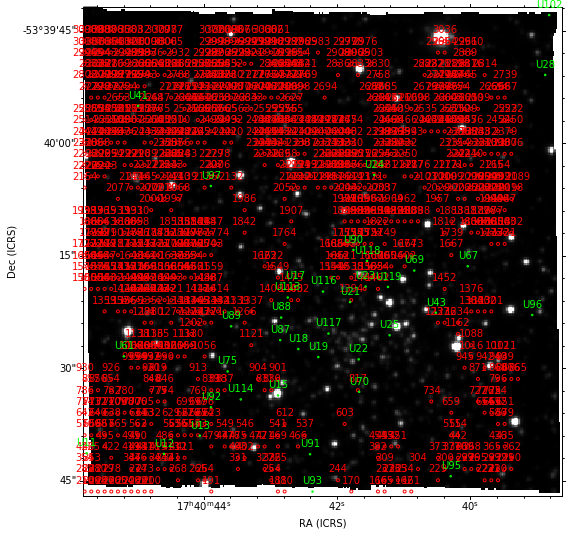

In [9]:
dwarf = aplpy.FITSFigure('IMAGE_FOV_0004.fits',hdu=1)

dwarf.show_colorscale(cmap='gray', vmin=49,vmax=37000)
dwarf.show_regions(regionfilename)
dwarf.show_regions('Cohn.reg')